In [1]:
# unzip 'library.zip'
unzip("library3.zip")
#zip('library3.zip','library')
# muda o diretorio da library
.libPaths("library")

In [ ]:
library(tidyverse)
library(tidymodels)
tidymodels_prefer()


# Aprendizado de maquina Supervisionado


1. Modelos de Regressão: Predição de valores numéricos
2. Modelos de Classificação: predição de valores categóricos

Vamos aplicar os modelos supervisionados mais comuns usando o tidymodels.

### Divisão de dados

Vamos separa os dados em conjunto de treino (80%) e teste (20%), esses valores podem variar conforme os dados disponíveis. recomendo para ate 1000 observações (com distribuições balanceadas da variável alvo) usar essa relação. Para conjunto maiores podemos aumentar o conjunto de testes.

In [16]:
set.seed(2024)
split= initial_split(iris, 0.8)
split

<Training/Testing/Total>
<120/30/150>

Observe como ficou a separação dos grupos. Agora vamos defini-los a novos dataframes

In [17]:
iris_train = training(split)
iris_test  =  testing(split)

summary(iris_train)

  Sepal.Length    Sepal.Width     Petal.Length    Petal.Width   
 Min.   :4.300   Min.   :2.000   Min.   :1.100   Min.   :0.100  
 1st Qu.:5.100   1st Qu.:2.800   1st Qu.:1.575   1st Qu.:0.275  
 Median :5.700   Median :3.000   Median :4.200   Median :1.300  
 Mean   :5.808   Mean   :3.043   Mean   :3.743   Mean   :1.199  
 3rd Qu.:6.400   3rd Qu.:3.300   3rd Qu.:5.100   3rd Qu.:1.800  
 Max.   :7.700   Max.   :4.400   Max.   :6.900   Max.   :2.500  
       Species  
 setosa    :41  
 versicolor:36  
 virginica :43  
                
                
                

Note que a versicolor foi menos amostrada para o conjunto de treino, podemos ajustar para manter a mesma proporção com os dados originais usando o argumento strata

In [ ]:
split= initial_split(iris, 0.8, strata = Species)
iris_train = training(split)
iris_test  =  testing(split)

summary(iris_train)

  Sepal.Length    Sepal.Width     Petal.Length    Petal.Width   
 Min.   :4.300   Min.   :2.200   Min.   :1.000   Min.   :0.100  
 1st Qu.:5.100   1st Qu.:2.800   1st Qu.:1.575   1st Qu.:0.200  
 Median :5.800   Median :3.000   Median :4.350   Median :1.300  
 Mean   :5.798   Mean   :3.034   Mean   :3.733   Mean   :1.179  
 3rd Qu.:6.400   3rd Qu.:3.300   3rd Qu.:5.100   3rd Qu.:1.800  
 Max.   :7.700   Max.   :4.400   Max.   :6.900   Max.   :2.500  
       Species  
 setosa    :40  
 versicolor:40  
 virginica :40  
                
                
                

### Workflow

Dentro do universo Tidymodels, quando se trata de uso de aprendizado de maquinas,utilizamos uma sequencia logica, que se mantêm constante na maioria dos modelos.

1. Split inicial entre dados de teste e treino (validação)
2. Receita quando necessária para o pré-processamento dos dados.
3. Definição do modelo a ser usado, No R utilize o `parsnip:::parsnip_addin()`
Note quem alguns modelos podem ser necessário a definição de regressão ou classificação. Alguns modelos possuem hiperparâmetros que podem ser ajustados.
4. Definição de um *Workflow*, uma sequencia de trabalho onde vamos adicionar o modelo e a receita ou a equação ao modelo. (Na próxima aula vamos ver mais passos)
5. *Fit* do modelo ou seja, treiná-lo para nosso conjunto de dados de treino.
6. *Predict*, fazer uma previsão com o conjunto de dados de teste (ou treino).
7. Usar métricas para averiguar a relação entre o previsto e observado.

Vamos iniciar trabalhando com o modelo de regressão linear, que já estamos familiarizados, aplicados aos dados do mtcars.

In [22]:
set.seed(2024)
# split dos dados em treino e teste
cars_split = initial_split(mtcars, prop = 0.80, strata = "cyl") # 80% de treino e statificado para o numero de cilindros
cars_train = training(cars_split)
cars_test  =  testing(cars_split)


# vamos estimar quantas cilindradas o carro possue.
#receita para os dados dos carros.
rec_cars= cars_train %>%
  recipe(disp~cyl+wt) %>%
  step_mutate_at("cyl",fn=as.factor)%>%
  step_dummy(all_factor())

# definição do modelo
lm_model = linear_reg() %>%
  set_engine("lm")

# no recipes vamos aplicar a um worflow, onde adicionamos o modelo e a receita.
lm_wflow =
  workflow() %>%
  add_model(lm_model) %>%
  add_recipe(rec_cars)

# vamos treinas o modelo com o conjunto de dados de treino.
lm_fit = fit(lm_wflow, cars_train)

lm_fit



══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_mutate_at()
• step_dummy()

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)           wt       cyl_X6       cyl_X8  
     -9.705       51.574       38.263      158.313  


Agora vamos obter mais informações estatísticas sobre o modelo.

In [23]:
# saida tradicional do lm quando não usado dentro do universo tidy
summary(extract_fit_engine(lm_fit))



Call:
stats::lm(formula = ..y ~ ., data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-82.715 -18.067   0.083  26.898  63.631 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -9.705     32.174  -0.302 0.766034    
wt            51.574     12.612   4.089 0.000571 ***
cyl_X6        38.263     24.090   1.588 0.127892    
cyl_X8       158.313     27.158   5.829 1.06e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 38.01 on 20 degrees of freedom
Multiple R-squared:  0.9149,	Adjusted R-squared:  0.9022 
F-statistic: 71.69 on 3 and 20 DF,  p-value: 7.064e-11


In [24]:
# outras formas
glance(lm_fit)
tidy(lm_fit)

r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
0.9149189,0.9021568,38.01433,71.68997,7.064213e-11,3,-119.1778,248.3556,254.2458,28901.78,20,24


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-9.705373,32.17438,-0.3016491,7.660337e-01
wt,51.574340,12.61188,4.0893449,5.708739e-04
cyl_X6,38.263054,24.08987,1.5883460,1.278923e-01
cyl_X8,158.312967,27.15803,5.8293236,1.055369e-05


Vamos avaliar o nosso modelo de regressão linear por meio de algumas métricas.




In [27]:
cars_metrics <- metric_set(rmse, rsq) # defino as metricas

# Vamos obter as metricas do conjunto de treino.
# note que adcionei a coluna de previsão aos dados do treino
cars_train %>% bind_cols(predict(lm_fit, new_data = cars_train)) %>%
  cars_metrics(truth = disp, estimate = .pred)

# vamos ver as metricas no conjunto de testes.
cars_test %>% bind_cols(predict(lm_fit, new_data = cars_test)) %>%
  cars_metrics(truth = disp, estimate = .pred)

# a função augment ja adciona ao conjunto de dados os valores previstos.
augment(lm_fit,new_data = cars_test) %>%
  cars_metrics(truth = disp, estimate = .pred) # ja coloca junto





.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,34.7021754
rsq,standard,0.9149189


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,34.2961189
rsq,standard,0.9406215


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,34.2961189
rsq,standard,0.9406215


É importante obtermos as métricas dos dados de treino para verificar a mudança destas métricas quando aplicados aos dados de teste, caso a diferença for grande, 10% no caso do R², temos um forte indicativo de um overfitting.
No caso do mtcars, como o conjunto de dados é pequeno, tivemos um melhor resultado no conjunto de testes, algo que não recorrente em maiores conjuntos de dados.

### Regressão logística

A regressão logística possui diversos [motores](https://parsnip.tidymodels.org/reference/logistic_reg.html), vamos utilizar o glm (generalized linear model). O uso comum da regressão logística é a determinação de classes Binarias.

Muito similar a regressão linear, porem não temos mais uma equação linear para encontrar o menor erro entre os pontos e sim uma função chamada de Logit:

$p(x)=\frac{1}{1+e^{-z}}$

Onde z é uma função da reta: $b_0 + b_1x_1 +b_2x_2 ....$

resolvendo para z:

$z=\log(\frac{p}{1-p})$


Outro ponto de diferença é que ao invés de utilizar o somatorio do erro quadratico (L2) para obter o melhor ajuste, se utiliza o LogLoss.

LogLoss = ∑-ylog(y')-(1-y)log(1-y')

Vamos ao exemplo de determinar se o carro é automático (0) ou manual(1).Neste exemplo vamos utilizar um meio gráfico.

`geom_smooth()` using formula = 'y ~ x'


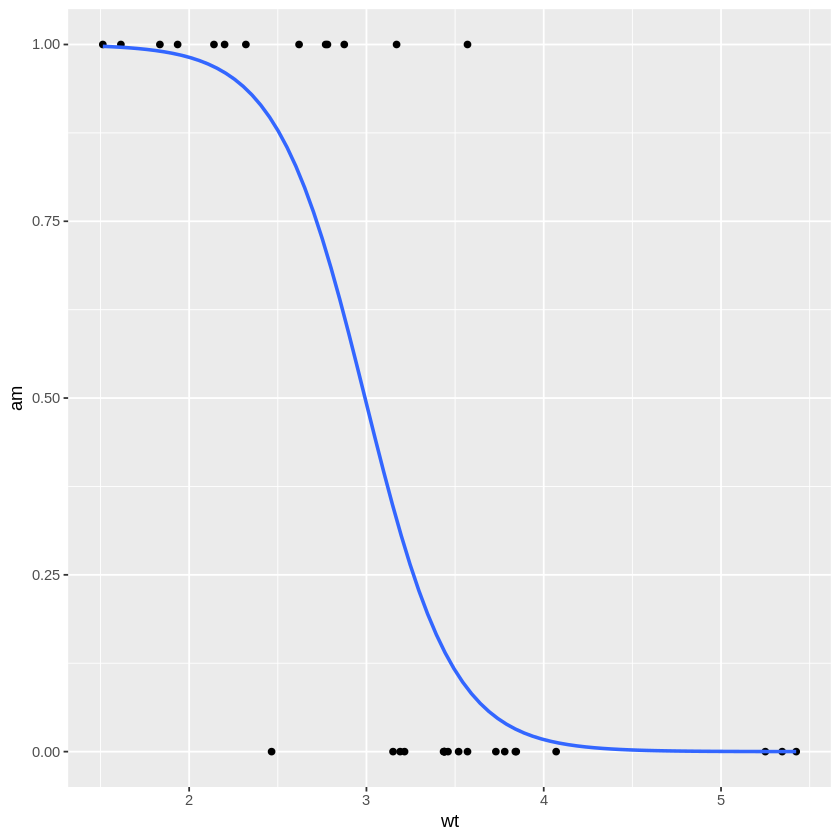

In [ ]:

mtcars %>% ggplot()+
  aes(x=wt,y=am)+
  geom_point()+
  geom_smooth(method = "glm", method.args= list(family=binomial),se=F)


Aplicando ao universo `tidymodels`

In [3]:

# determinação do modelo
logit_model <-
  logistic_reg() %>%
  set_engine('glm')

# vamos determinar o que vão ser os fatores.
mtcars <- as_tibble(mtcars) %>%
  mutate(across(where(~ n_distinct(.) < 10), as.factor))

# vamos fazer um split stratificando com o "am"
set.seed(2024)
cars_split <- initial_split(mtcars, prop = 0.80, strata = "am")
cars_train <- training(cars_split)
cars_test  <-  testing(cars_split)

# definição do workflow
# note que como não vou usar o recipes, posso apenas adicionar a formula.
logit_wflow <-
  workflow() %>%
  add_model(logit_model) %>%
  add_formula(am~wt)

logit_fit <- fit(logit_wflow, cars_train)

logit_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Formula
Model: logistic_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
am ~ wt

── Model ───────────────────────────────────────────────────────────────────────

Call:  stats::glm(formula = ..y ~ ., family = stats::binomial, data = data)

Coefficients:
(Intercept)           wt  
     10.787       -3.725  

Degrees of Freedom: 24 Total (i.e. Null);  23 Residual
Null Deviance:	    33.65 
Residual Deviance: 14.99 	AIC: 18.99

Vamos observar algumas métricas de Classificação

In [47]:
cars_metrics <- metric_set(accuracy, f_meas) # defino as metricas para classificação


augment(logit_fit,new_data = cars_train) %>%
  cars_metrics(truth = am, estimate = .pred_class)

# note que a matriz de confusão tem que ser feita a parte.
augment(logit_fit,new_data = cars_train) %>%
  conf_mat(truth = am, estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9200000
f_meas,binary,0.9333333


          Truth
Prediction  0  1
         0 14  1
         1  1  9

Comparando com o gráfico anterior, observamos na matriz de confusão os 3 pontos esperados de classificação equivocada.
Agora vamos observar os dados acionados ao conjunto de dados.

In [48]:
augment(logit_fit,new_data = cars_train)

.pred_class,.pred_0,.pred_1,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
<fct>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>
0,0.766541182,2.334588e-01,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
0,0.883606296,1.163937e-01,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2
0,0.924930056,7.506994e-02,14.3,8,360.0,245,3.21,3.570,15.84,0,0,3,4
0,0.749463858,2.505361e-01,24.4,4,146.7,62,3.69,3.190,20.00,1,0,4,2
0,0.720461185,2.795388e-01,22.8,4,140.8,95,3.92,3.150,22.90,1,0,4,2
0,0.883606296,1.163937e-01,17.8,6,167.6,123,3.92,3.440,18.90,1,0,4,4
0,0.987554276,1.244572e-02,16.4,8,275.8,180,3.07,4.070,17.40,0,0,3,3
0,0.957193513,4.280649e-02,17.3,8,275.8,180,3.07,3.730,17.60,0,0,3,3
0,0.964207618,3.579238e-02,15.2,8,275.8,180,3.07,3.780,18.00,0,0,3,3


Comparando com o conjunto de testes.

In [49]:

augment(logit_fit,new_data = cars_test) %>%
  cars_metrics(truth = am, estimate = .pred_class) # ja coloca junto

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8571429
f_meas,binary,0.8888889


Agora podemos melhorar o modelo acrecendo mais uma variável, refaça o exemplo adicionado o "mpg"

In [50]:
logit_wflow <-
  workflow() %>%
  add_model(logit_model) %>%
  add_formula(am~wt+mpg)

logit_fit <- fit(logit_wflow, cars_train)

logit_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Formula
Model: logistic_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
am ~ wt + mpg

── Model ───────────────────────────────────────────────────────────────────────

Call:  stats::glm(formula = ..y ~ ., family = stats::binomial, data = data)

Coefficients:
(Intercept)           wt          mpg  
    18.6371      -5.0251      -0.1901  

Degrees of Freedom: 24 Total (i.e. Null);  22 Residual
Null Deviance:	    33.65 
Residual Deviance: 14.35 	AIC: 20.35

In [51]:
augment(logit_fit,new_data = cars_train) %>%
  cars_metrics(truth = am, estimate = .pred_class)

augment(logit_fit,new_data = cars_train) %>%
  conf_mat(truth = am, estimate = .pred_class)

augment(logit_fit,new_data = cars_test) %>%
  cars_metrics(truth = am, estimate = .pred_class) # ja coloca junto

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9200000
f_meas,binary,0.9333333


          Truth
Prediction  0  1
         0 14  1
         1  1  9

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8571429
f_meas,binary,0.8888889


### K- Vizinhos mais proximos (KNN)

O KNN Define a classe do novo ponto baseado na distancia dos pontos mais próximos a eles, são escolhidos K pontos mais próximos para definir por votação simples ou seja, quem tem mais ponto da mesma classe proxima define a classificação do novo ponto.


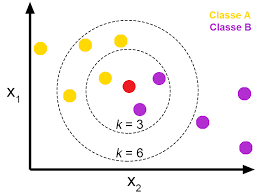

O modelo de [KNN](https://parsnip.tidymodels.org/reference/nearest_neighbor.html) (k-nearest_neighbor), possui uma serie de hiperparametros a serem escolhidos, vamos destacar:

1. neighbors:defini quantos vizinhos próximos vão ser levando em conta no processamento
2. weight_func: a função de peso, que determina quais seram os pesos de cada um destes pontos. "rectangular" define os pesoas como iguais, depois temos uma series de Funções que determinam os pesos em função das suas distancias,podemos destacar, "triangular", o peso diminui linearmente com a distancia,"Biweight" (quadrática), diminui ao peso de forma quadrática, ou seja, quanto mais distante menor vai ser o impacto, "Rank" baseia pela ordem de proximidade, não pela distancia. "Optimal" baseia-se na minimização do erro quadrático médio. pode levar a overfiiting.




In [77]:
#install.packages("kknn")
set.seed(2024)
knn_model =
  nearest_neighbor(neighbors = 3, weight_func = 'rectangular') %>%
  set_engine('kknn') %>%
  set_mode('classification')

# os dados devem estar nomalizados
rec_cars= cars_train %>% recipe(cyl~disp+wt) %>%
  step_normalize(all_double_predictors())



knn_wflow =
  workflow() %>%
  add_model(knn_model) %>%
  add_recipe(rec_cars)

knn_fit = fit(knn_wflow, cars_train)

knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_normalize()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(3,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.28
Best kernel: rectangular
Best k: 3

In [78]:
cars_metrics = metric_set(accuracy, f_meas) # defino as metricas para classificação

augment(knn_fit,new_data = cars_train) %>%
  cars_metrics(truth = cyl, estimate = .pred_class)

augment(knn_fit,new_data = cars_test) %>%
  cars_metrics(truth = cyl, estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9200000
f_meas,macro,0.8585231


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.8571429
f_meas,macro,0.8222222


Vamos ver a visualização grafica do espaço de classificação

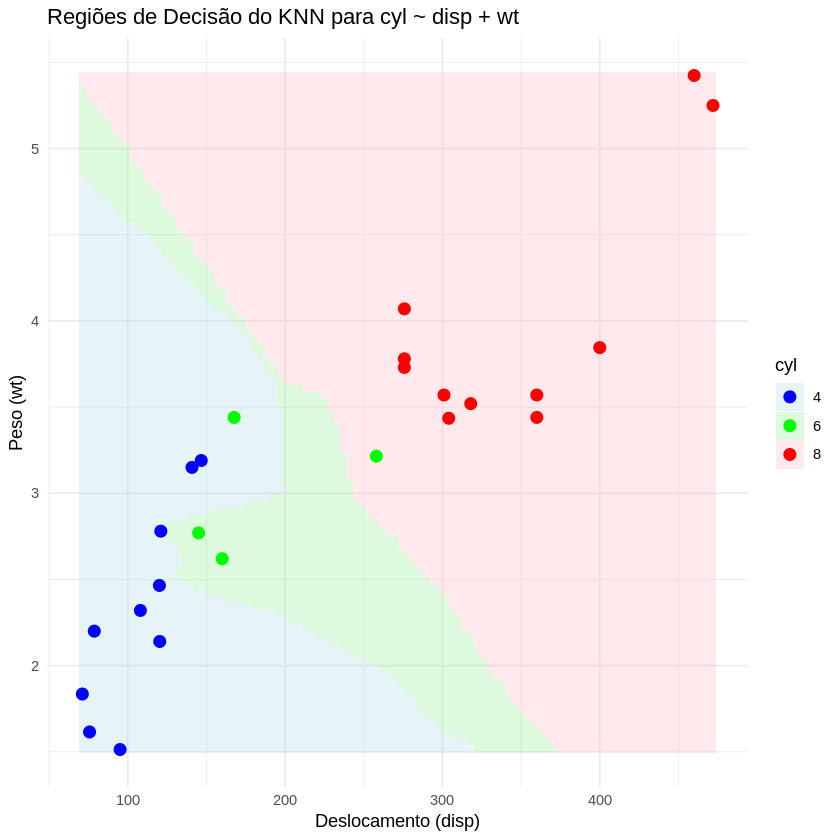

In [79]:
# Cria uma grade de valores para prever e visualizar regiões de decisão
grid = expand.grid(
  disp = seq(min(mtcars$disp), max(mtcars$disp), length.out = 100),
  wt = seq(min(mtcars$wt), max(mtcars$wt), length.out = 100)
) %>%
  mutate(cyl = predict(knn_fit, .) %>% pull(.pred_class))

# Plotar regiões de decisão e os dados de treino
ggplot(grid, aes(x = disp, y = wt)) +
  geom_tile(aes(fill = cyl), alpha = 0.3) +
  geom_point(data = cars_train, aes(color = cyl), size = 3) +
  labs(title = "Regiões de Decisão do KNN para cyl ~ disp + wt",
       x = "Deslocamento (disp)",
       y = "Peso (wt)") +
  theme_minimal() +
  scale_fill_manual(values = c("4" = "lightblue", "6" = "lightgreen", "8" = "lightpink")) +
  scale_color_manual(values = c("4" = "blue", "6" = "green", "8" = "red"))

Podemos utilizar em modo de regressão onde os valor do novo ponto pe a media dos k pontos mais proximos:

In [70]:
rec_cars= cars_train %>% recipe(mpg~.) %>%
  step_normalize(all_double_predictors())%>%
  step_dummy(all_factor())

knn_model <-
  nearest_neighbor(neighbors = 2, weight_func = 'optimal') %>%
  set_engine('kknn') %>%
  set_mode('regression')

knn_wflow =
  workflow() %>%
  add_model(knn_model) %>%
  add_recipe(rec_cars)

knn_fit = fit(knn_wflow, cars_train)

cars_metrics = metric_set(rsq, rmse) # defino as metricas

augment(knn_fit,new_data = cars_train) %>%
  cars_metrics(truth = mpg, estimate = .pred)


augment(knn_fit,new_data = cars_test) %>%
  cars_metrics(truth = mpg, estimate = .pred)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rsq,standard,0.9907528
rmse,standard,0.6043913


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rsq,standard,0.8992514
rmse,standard,3.0221103


Nitidamente temos um modelo com overffiting, como corrigi-lo?

### Máquinas de Vetores de Suporte (SVM)

O objetivo do SVM é separar os conjuntos de dados por meio de um hiperplano, esse hiperplano é defino como um numero menor da dimensão dos dados, no caso de duas dimensões o hiperplano definido pelo SVM sera uma reta, caso 3 dimensões sera definido como um plano e assim sucessivamente.
Como podemos observar na figura, o hiperplano (reta) é posicionado com base em maximizar a distancia da margem entre os pontos de suporte (vetores de suporte).

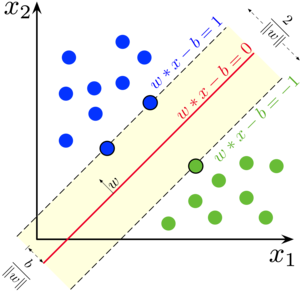

Equação da reta: $w_1x_1 + w_2x_2 - b = 0$

hiperplano generico: $w_ix_i - b = 0$

Objetivo: Maximizar a distância entre as margens: $d = {2}/{||w||}$

Sendo assim tenho que minimizar o ||w||

E podemos permitir alguns erros, para tornar as margem mais flexível em busca do melhor ajuste, para isso, podemos acrescentar uma possibilidade de erro ponderada por um coeficiente "C":

para o mínimo de: ${||w||} + C\sum{\\erro_i}$

Quanto maior o C menor é a tolerância da margem com os erros.

E quando não podemos separa com um plano na mesma dimensão, podemos utilizar o truque do kernel, que simula os dados em uma maior dimensão para poder encontrar o hiperplano como ilustrado na figura.

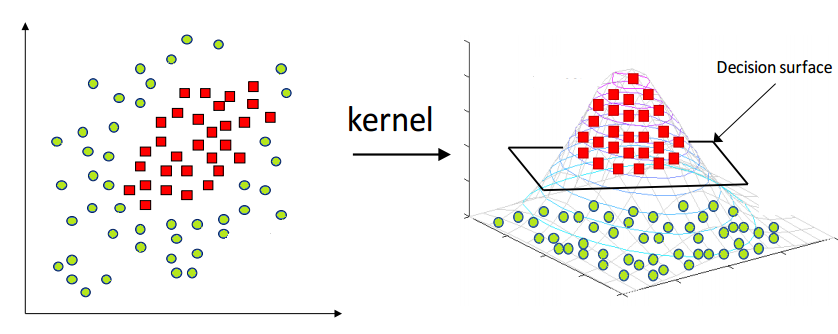

Temos 3 tipos de Kernel a utilizar para o SVM.


1.   [Linear](https://parsnip.tidymodels.org/reference/svm_linear.html)> para quando você reconhecer uma separação linear
2.   [Polinomial](https://parsnip.tidymodels.org/reference/svm_poly.html)> quando a separação for mais complexa
3.   [Radial basis function](https://parsnip.tidymodels.org/reference/svm_rbf.html)> quando desconhece a relação de agrupamento





Installing package into ‘/content/library’
(as ‘lib’ is unspecified)



 Setting default kernel parameters  


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: svm_linear()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_normalize()

── Model ───────────────────────────────────────────────────────────────────────
Support Vector Machine object of class "ksvm" 

SV type: C-svc  (classification) 
 parameter : cost C = 1 

Linear (vanilla) kernel function. 

Number of Support Vectors : 12 

Objective Function Value : -7.6162 
Training error : 0.04 
Probability model included. 

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9600000
f_meas,binary,0.9655172


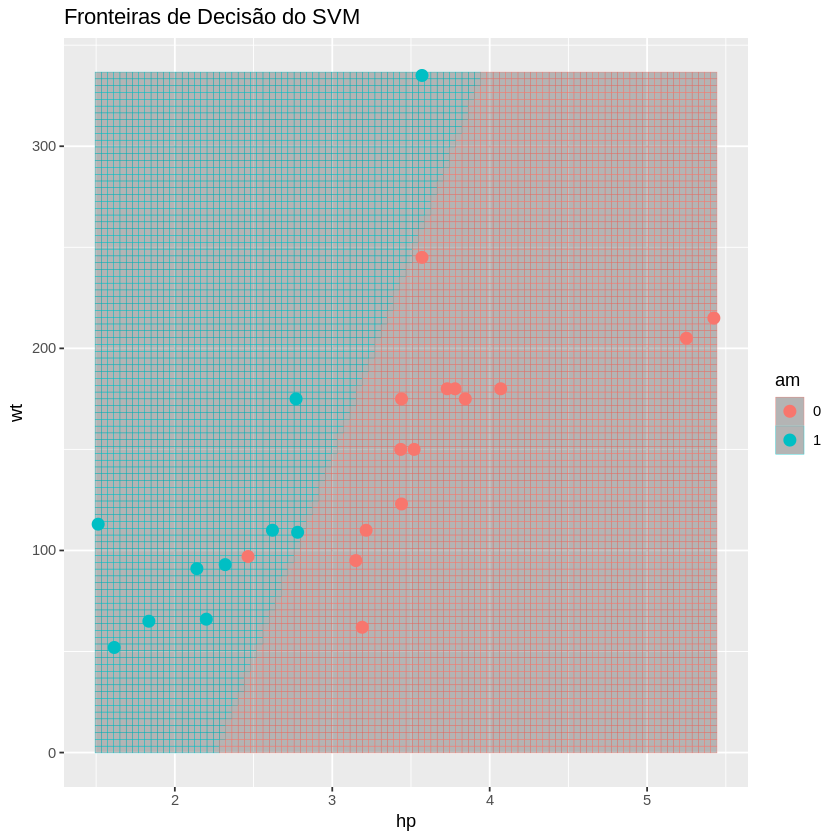

In [4]:
#install.packages('kernlab')
svm_model <-
  svm_linear() %>%
  set_engine('kernlab') %>%
  set_mode('classification')

 # Os dados deve estar nomalizados
rec_cars= cars_train %>% recipe(am~wt+hp) %>%
  step_normalize(all_double_predictors())

svm_wflow <-
  workflow() %>%
  add_model(svm_model) %>%
  add_recipe(rec_cars)

svm_fit = fit(svm_wflow, cars_train)
svm_fit

cars_metrics = metric_set(accuracy, f_meas) # defino as metricas

augment(svm_fit,new_data = cars_train) %>%
  cars_metrics(truth = am, estimate = .pred_class)


grid = expand.grid(
  wt = seq(min(mtcars$wt), max(mtcars$wt), length.out = 100),
  hp = seq(min(mtcars$wt), max(mtcars$hp), length.out = 100)
) %>%
  mutate(am = predict(svm_fit, .) %>% pull(.pred_class))

# Plotar regiões de decisão e os dados de treino
ggplot(grid, aes(x = wt, y = hp, color = am)) +
  geom_tile(alpha = 0.3) +
  geom_point(data = cars_train, aes(color = am), size = 3) +
  labs(title = "Fronteiras de Decisão do SVM", x = "hp", y = "wt")


Conseguimos um a separação Melhor com um kernel polinomial?
O kernel polinomial, temos um hiperparametro do grau do polinomial(degree)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9600000
f_meas,binary,0.9655172


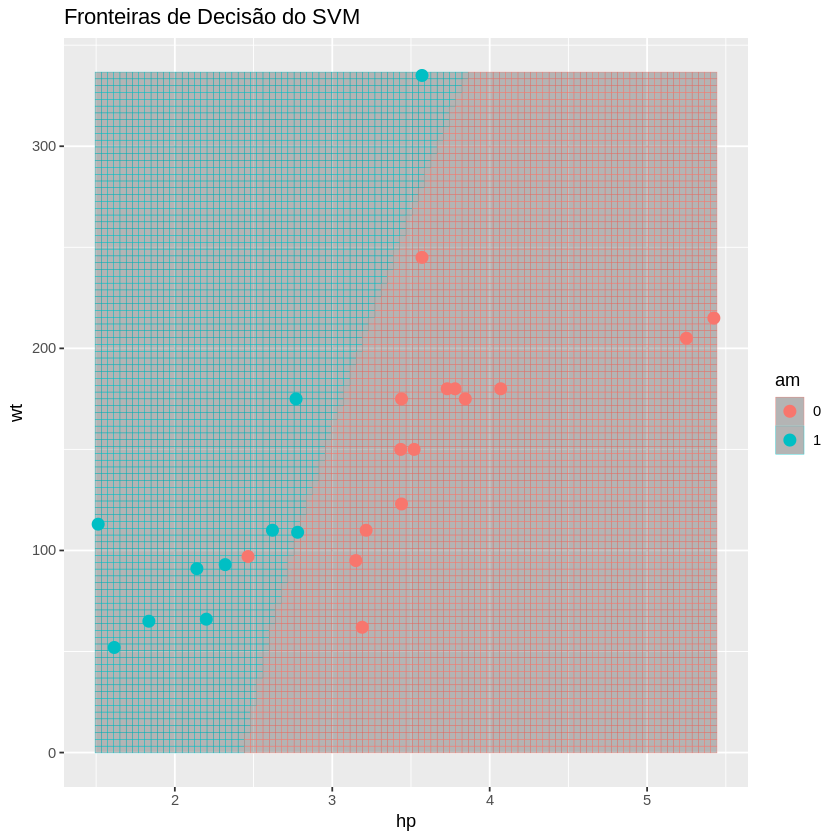

In [95]:
svm_model <-
  svm_poly(degree=2) %>%
  set_engine('kernlab') %>%
  set_mode('classification')

 # Os dados deve estar nomalizados
rec_cars= cars_train %>% recipe(am~wt+hp) %>%
  step_normalize(all_double_predictors())

svm_wflow <-
  workflow() %>%
  add_model(svm_model) %>%
  add_recipe(rec_cars)

svm_fit = fit(svm_wflow, cars_train)


cars_metrics = metric_set(accuracy, f_meas) # defino as metricas

augment(svm_fit,new_data = cars_train) %>%
  cars_metrics(truth = am, estimate = .pred_class)


grid = expand.grid(
  wt = seq(min(mtcars$wt), max(mtcars$wt), length.out = 100),
  hp = seq(min(mtcars$wt), max(mtcars$hp), length.out = 100)
) %>%
  mutate(am = predict(svm_fit, .) %>% pull(.pred_class))

# Plotar regiões de decisão e os dados de treino
ggplot(grid, aes(x = wt, y = hp, color = am)) +
  geom_tile(alpha = 0.3) +
  geom_point(data = cars_train, aes(color = am), size = 3) +
  labs(title = "Fronteiras de Decisão do SVM", x = "hp", y = "wt")

Pode ser utilizado para mais classes.

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.8800000
f_meas,macro,0.7565217


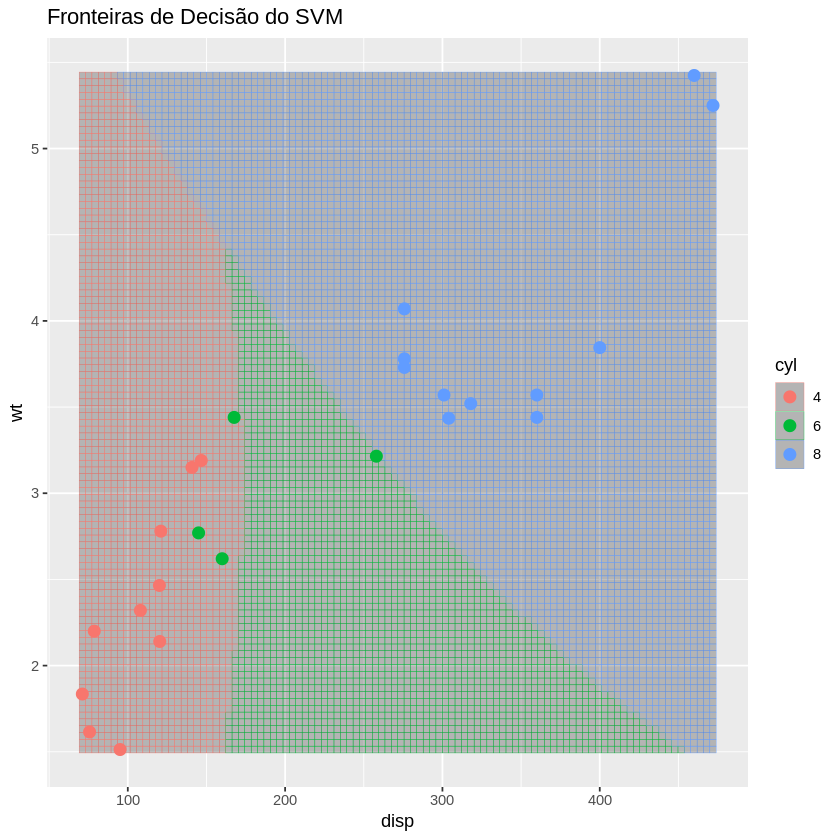

In [6]:
svm_model <-
  svm_poly(degree = 2) %>%
  set_engine('kernlab') %>%
  set_mode('classification')

rec_cars= cars_train %>% recipe(cyl~disp+wt) %>%
  step_normalize(all_double_predictors())

svm_wflow <-
  workflow() %>%
  add_model(svm_model) %>%
  add_recipe(rec_cars)

svm_fit = fit(svm_wflow, cars_train)

cars_metrics = metric_set(accuracy, f_meas) # defino as metricas

augment(svm_fit,new_data = cars_train) %>%
  cars_metrics(truth = cyl, estimate = .pred_class)


grid = expand.grid(
  disp = seq(min(mtcars$disp), max(mtcars$disp), length.out = 100),
  wt = seq(min(mtcars$wt), max(mtcars$wt), length.out = 100)
) %>%
  mutate(cyl = predict(svm_fit, .) %>% pull(.pred_class))

# Plotar regiões de decisão e os dados de treino
ggplot(grid, aes(x = disp, y = wt, color = cyl)) +
  geom_tile(alpha = 0.3) +
  geom_point(data = cars_train, aes(color = cyl), size = 3) +
  labs(title = "Fronteiras de Decisão do SVM", x = "disp", y = "wt")


Aumente o grau do polinômio e utilize o kernel gaussiano

Em seguida vamos a um exemplo mais complexo

Installing package into ‘/content/library’
(as ‘lib’ is unspecified)



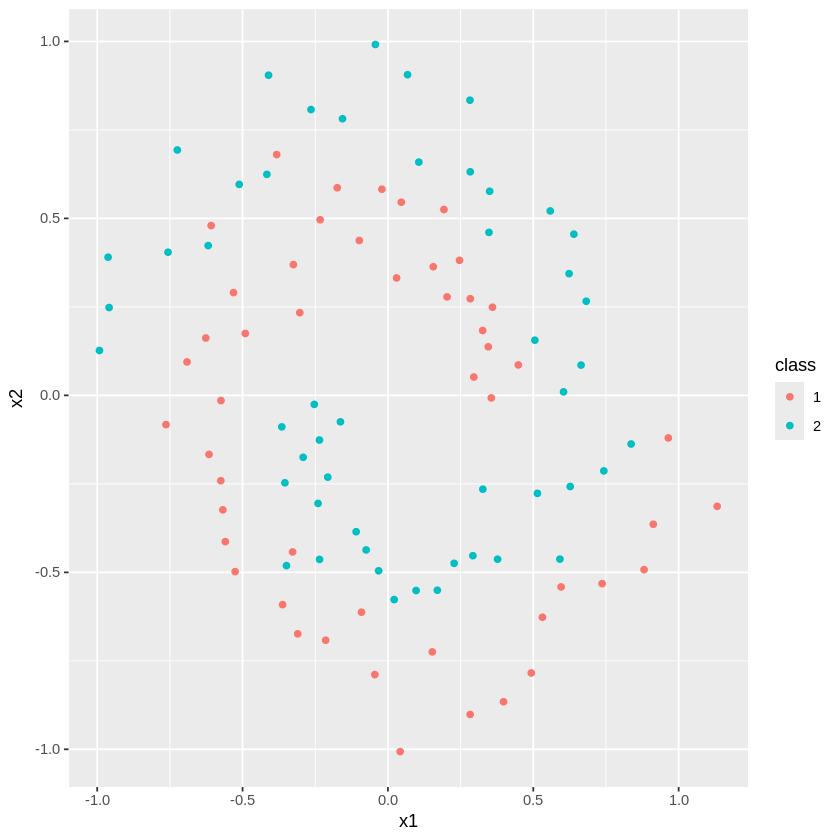

In [97]:
#install.packages('mlbench')
library(mlbench)
# Criar dados

data <- mlbench.spirals(100, 1, 0.1)
df <- data.frame(x1 = data$x[, 1], x2 = data$x[, 2], class = as.factor(data$classes))

ggplot(df, aes(x = x1, y = x2, color = class)) +
 geom_point()

Vamos começar com o linear, plolynomio de grau 1

 Setting default kernel parameters  


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5100000
f_meas,binary,0.5148515


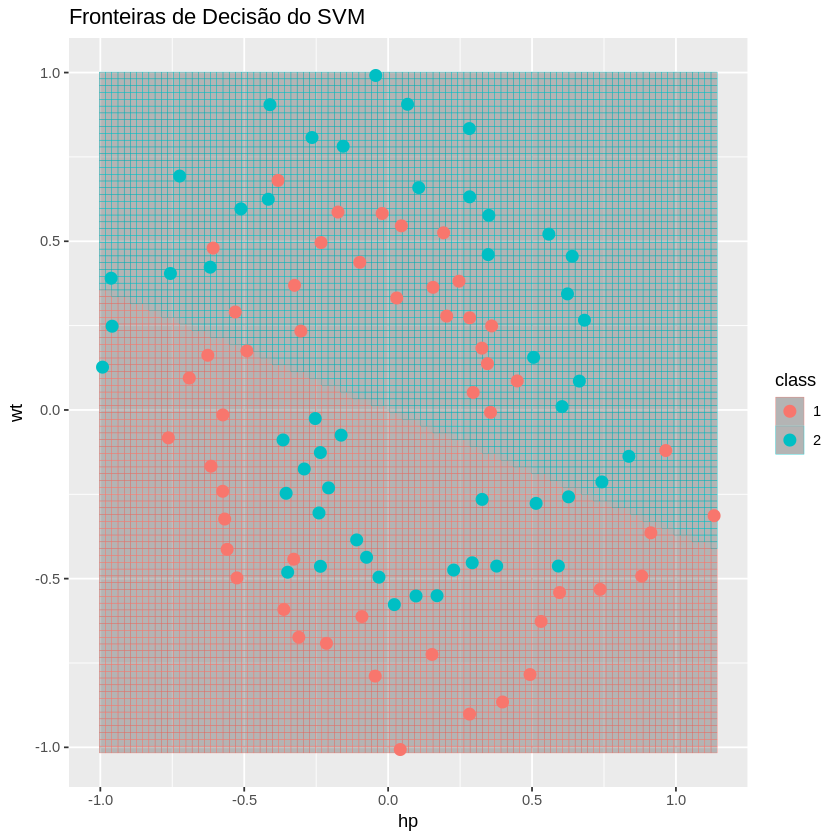

In [99]:

svm_model <-
  svm_poly() %>%
  set_engine('kernlab') %>%
  set_mode('classification')


svm_wflow <-
  workflow() %>%
  add_model(svm_model) %>%
  add_formula(class~x1+x2)

svm_fit = fit(svm_wflow, df)


cars_metrics = metric_set(accuracy, f_meas) # defino as metricas

augment(svm_fit,new_data = df) %>%
  cars_metrics(truth = class, estimate = .pred_class)


grid = expand.grid(
  x1 = seq(min(df$x1), max(df$x1), length.out = 100),
  x2 = seq(min(df$x2), max(df$x2), length.out = 100)
) %>%
  mutate(class = predict(svm_fit, .) %>% pull(.pred_class))

# Plotar regiões de decisão e os dados de treino
ggplot(grid, aes(x = x1, y = x2, color = class)) +
  geom_tile(alpha = 0.3) +
  geom_point(data = df, aes(color = class), size = 3) +
  labs(title = "Fronteiras de Decisão do SVM", x = "hp", y = "wt")

Vamos utilizar a metrica Roc_Auc para avaliar.

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
roc_auc,binary,0.61


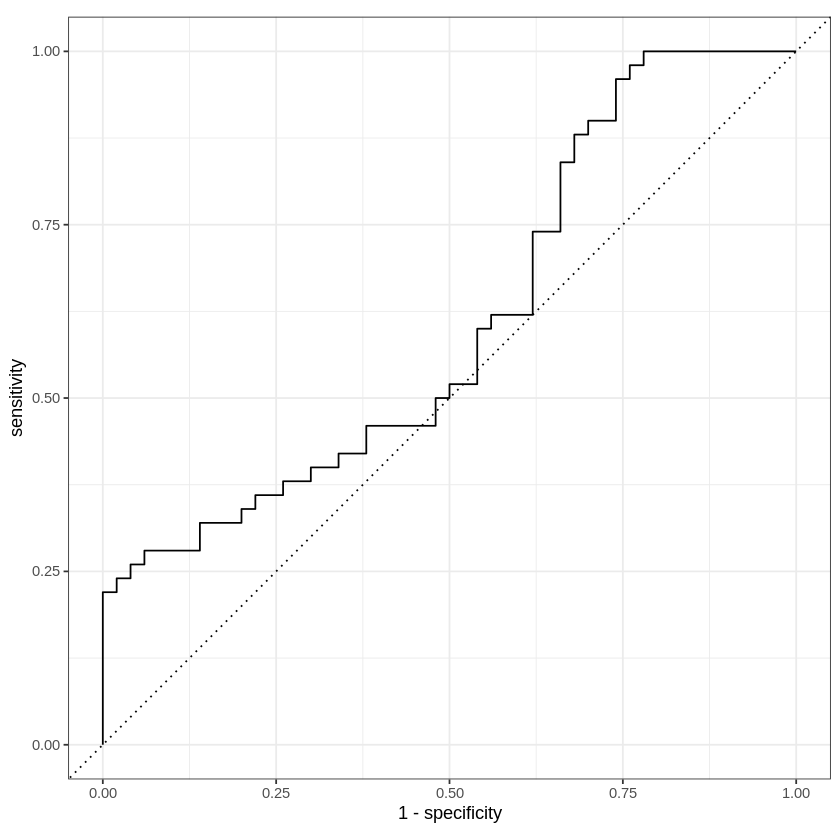

In [100]:
 augment(svm_fit,new_data = df) %>%
   roc_auc(truth = class,.pred_1)

 # podemos ver curva
 roc_curve(augment(svm_fit,new_data = df),truth = class,.pred_1) %>% autoplot()



Um kernel linear não é o melhor ajuste, use polinômios de maior grau e kernel gaussiano, e a métrica roc_auc para definir o melhor ajuste.

Em seguida vamos utilizar os dados do titanic para ver qual modelo melhor se ajusta para definir a sobrevivência.

In [12]:
titanic=read.csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')

titanic = titanic %>%
  mutate(across(where(~ n_distinct(.) < 10), as.factor)) %>% na.omit()

set.seed(2024)

titanic_split = initial_split(titanic, prop = 0.80, strata = "Survived")
df_train = training(titanic_split)
df_test  =  testing(titanic_split)

#receita para os modelos
rec_df= df_train %>%
  recipe(Survived~Age+Sex+Pclass) %>%
  step_normalize(all_double_predictors())%>%
  step_dummy(all_factor_predictors())


Logistica

In [19]:


# definição do modelo
lm_model = logistic_reg() %>%
  set_engine("glm")

# no recipes vamos aplicar a um worflow, onde adicionamos o modelo e a receita.
logit_wflow <-
  workflow() %>%
  add_model(lm_model) %>%
  add_recipe(rec_df)

logit_fit <- fit(logit_wflow, df_train)
logit_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: logistic_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_normalize()
• step_dummy()

── Model ───────────────────────────────────────────────────────────────────────

Call:  stats::glm(formula = ..y ~ ., family = stats::binomial, data = data)

Coefficients:
(Intercept)          Age     Sex_male    Pclass_X2    Pclass_X3  
     2.7277      -0.4676      -2.5638      -1.3415      -2.6574  

Degrees of Freedom: 570 Total (i.e. Null);  566 Residual
Null Deviance:	    771.4 
Residual Deviance: 512.6 	AIC: 522.6

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
roc_auc,binary,0.8382353


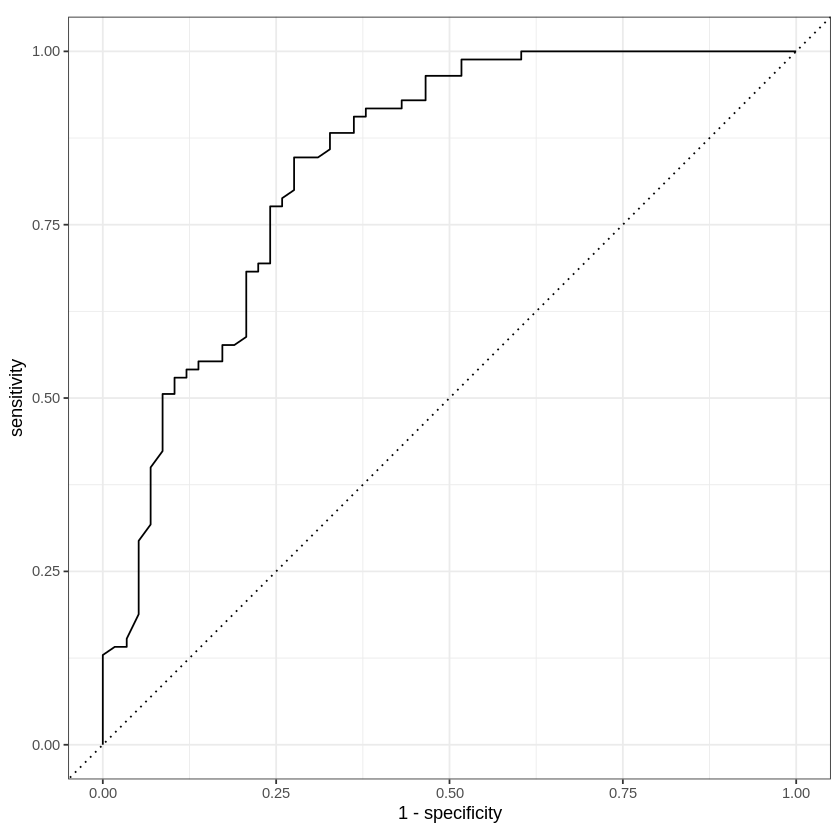

In [24]:
 augment(logit_fit,new_data = df_test) %>%
   roc_auc(truth = Survived,.pred_0)
 roc_curve(augment(logit_fit,new_data = df_test),truth = Survived,.pred_0) %>% autoplot()

KNN

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7972028
f_meas,binary,0.8397790


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
roc_auc,binary,0.8418864


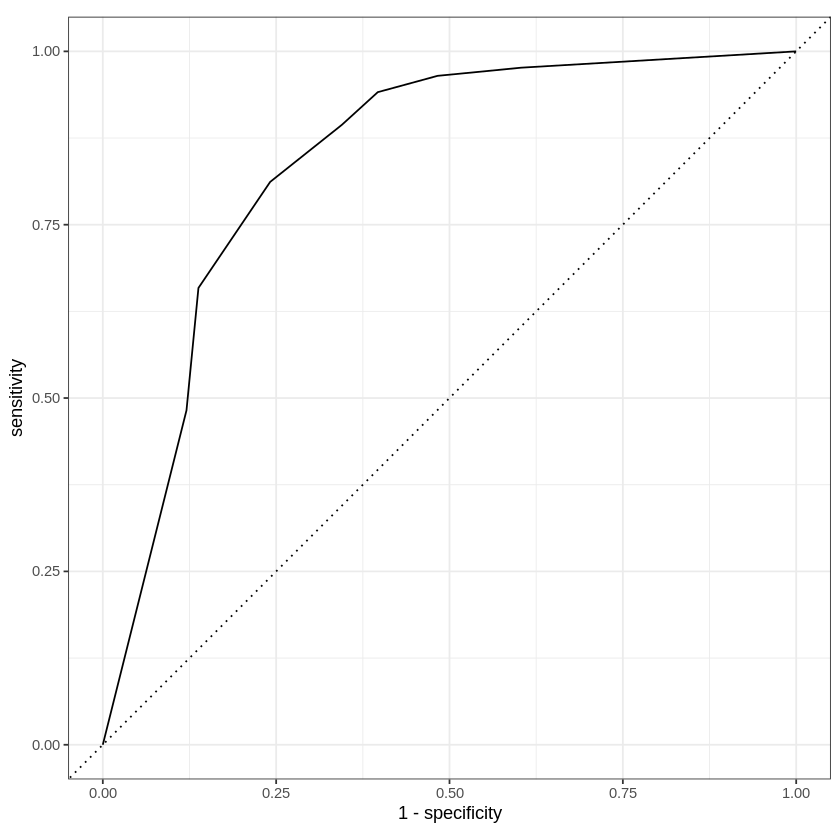

In [14]:
# definição do modelo
knn_model <-
  nearest_neighbor(neighbors = 7, weight_func = 'rectangular') %>%
  set_engine('kknn') %>%
  set_mode('classification')

# no recipes vamos aplicar a um worflow, onde adicionamos o modelo e a receita.
knn_wflow <-
  workflow() %>%
  add_model(knn_model) %>%
  add_recipe(rec_df)

knn_fit = fit(knn_wflow, df_train)

df_metrics = metric_set(accuracy, f_meas) # defino as metricas

augment(knn_fit,new_data = df_test) %>%
  df_metrics(truth = Survived, estimate = .pred_class)

 augment(knn_fit,new_data = df_test) %>%
   roc_auc(truth = Survived,.pred_0)
 roc_curve(augment(knn_fit,new_data = df_test),truth = Survived,.pred_0) %>% autoplot()

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7552448
f_meas,binary,0.8044693


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
roc_auc,binary,0.8218053


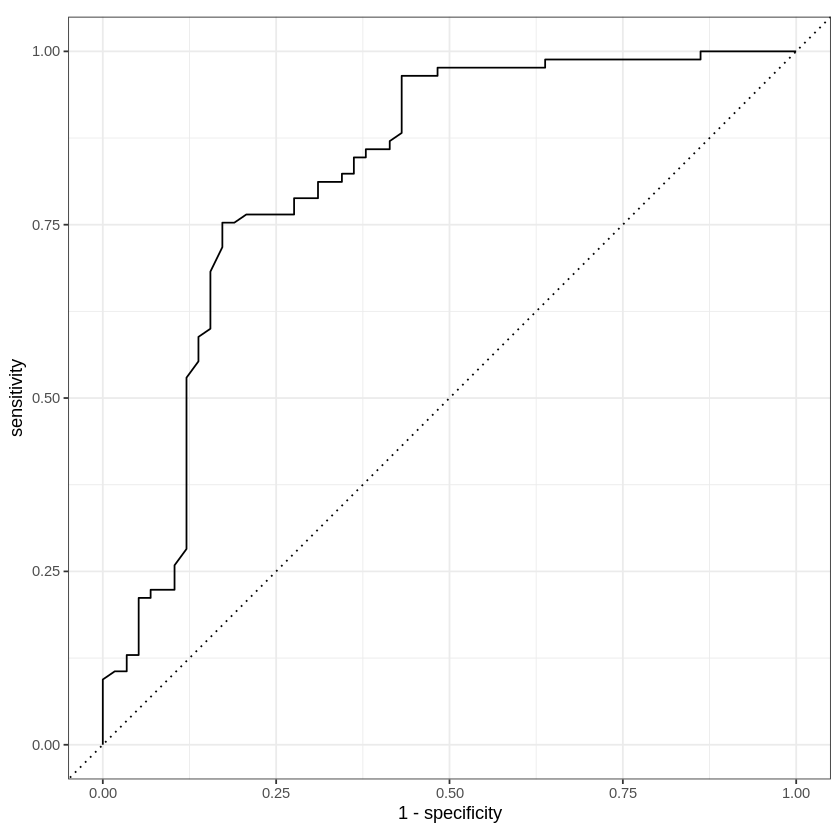

In [86]:
#install.packages('kernlab')
set.seed(2024)
svm_model <-
  svm_rbf() %>%
  set_engine('kernlab') %>%
  set_mode('classification')


# no recipes vamos aplicar a um worflow, onde adicionamos o modelo e a receita.
svm_wflow <-
  workflow() %>%
  add_model(svm_model) %>%
  add_recipe(rec_df)

svm_fit = fit(svm_wflow, df_train)

df_metrics = metric_set(accuracy, f_meas) # defino as metricas

augment(svm_fit,new_data = df_test) %>%
  df_metrics(truth = Survived, estimate = .pred_class)

 augment(svm_fit,new_data = df_test) %>%
   roc_auc(truth = Survived,.pred_0)
 roc_curve(augment(svm_fit,new_data = df_test),truth = Survived,.pred_0) %>% autoplot()